In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import umap


import joblib
from itertools import product
# optional, for progress bars
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon

def get_bootstrap_aucs(y_true, y_pred, bootstrap_iters=100):
    rng = np.random.RandomState(seed=42)
    idxs = list(range(y_pred.shape[0]))
    
    bootstrap_aucs = []
    for _ in range(bootstrap_iters):
        curr_idxs = rng.choice(idxs, size=len(idxs), replace=True)
        bootstrap_aucs.append(roc_auc_score(y_true[curr_idxs], y_pred[curr_idxs],
                                            multi_class='ovr', average='macro'))

    return np.median(bootstrap_aucs), bootstrap_aucs
    
def get_p_values(all_aucs):
    all_aucs = np.vstack(all_aucs)
    median_aucs = np.median(all_aucs, -1)
    second_best_idx, best_idx = median_aucs.argsort()[-2:] 
    p_val = wilcoxon(all_aucs[best_idx], all_aucs[second_best_idx])[1]
    return p_val, (second_best_idx, best_idx)

def pval_to_str(p_val):
    if p_val < 0.0001:
        p_val = 'p<0.0001'
        p_val = '***'
    else:
        p_val = f'p={p_val:.4f}'
    return p_val

def darken_hex(hex_color, factor=0.5):
    # Ensure the factor is between 0 and 1
    factor = max(0, min(factor, 1))

    # Remove the hash symbol if present
    hex_color = hex_color.lstrip('#')

    # Convert hex to RGB
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

    # Darken the RGB values by multiplying by the factor
    darkened_rgb = tuple(int(c * factor) for c in rgb)

    # Convert the RGB values back to hex
    darkened_hex = '#{:02x}{:02x}{:02x}'.format(*darkened_rgb)

    return darkened_hex




In [2]:
dftrain = pd.read_csv('/mnt/c/Users/Justin/Desktop/retina_imaging_datasets/ROP_dataset/dftrain.csv')
dftest = pd.read_csv('/mnt/c/Users/Justin/Desktop/retina_imaging_datasets/ROP_dataset/dftest.csv')

target_col = 'class'
dataset = 'Retinopathy of Prematurity (ROP)'
name_X_list = [
    ('RETFound-MEH', 
     '/home/justin/RETFound_MAE/ROP_Train_RETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/ROP_Test_RETFound_Feature_latent.npy'),
    ('DERETFound', 
     '/home/justin/RETFound_MAE/ROP_Train_DERETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/ROP_Test_DERETFound_Feature_latent.npy'),
    ('RETFound-Green', 
     'ROP_Train_X_ours.npy',
     'ROP_Test_X_ours.npy'),
]

target_to_colour = {
    'Normal': 'gold',
    'laser_scars': 'crimson',
    'Stage_1_ROP': 'cornflowerblue',
    'Stage_2_ROP': 'royalblue',
    'Stage_3_ROP': 'navy',
}
models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green']
colors = ['#ff595e', '#ffca3a', '#8ac926']  # Colors for models


  0%|          | 0/3 [00:00<?, ?it/s]

RETFound-MEH
DERETFound
RETFound-Green


Normal vs Rest         Laser Scars vs Rest          \
                        Logit     KNN               Logit     KNN   
RETFound-MEH           0.6965  0.7182              0.6762  0.6743   
DERETFound             0.7167  0.6868              0.6489  0.5828   
RETFound-Green         0.9593  0.9158              0.7929  0.7730   

               Any ROP vs Rest         Stage 1 vs Rest          \
                         Logit     KNN           Logit     KNN   
RETFound-MEH            0.5386  0.5476          0.5215  0.5232   
DERETFound              0.5823  0.5362          0.5554  0.5267   
RETFound-Green          0.8169  0.7913          0.7254  0.5867   

               Stage 2 vs Rest         Stage 3 vs Rest          
                         Logit     KNN           Logit     KNN  
RETFound-MEH            0.5248  0.5549          0.6100  0.5371  
DERETFound              0.5722  0.5381          0.6019  0.6111  
RETFound-Green          0.7656  0.5660          0.6318  0.6138

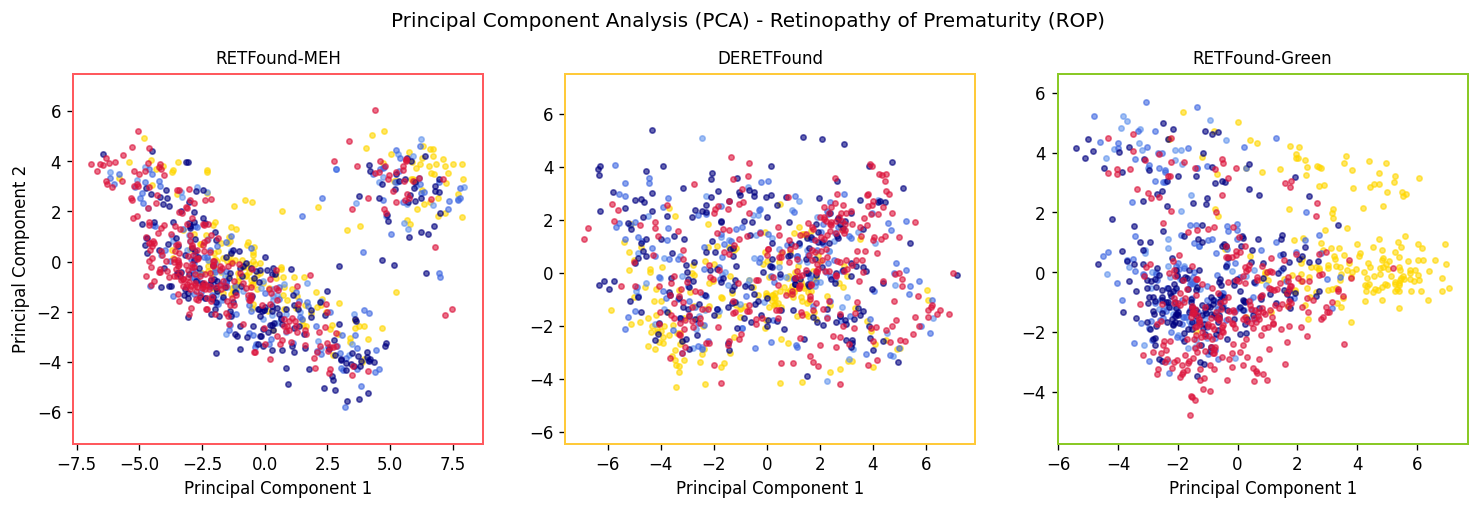

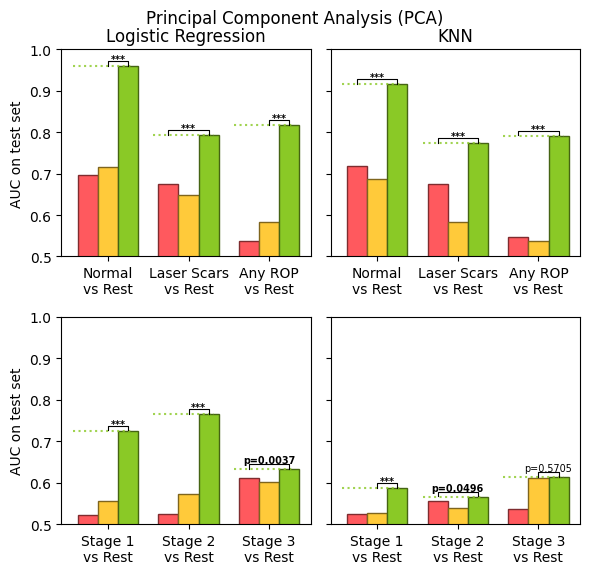

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=120)

target_cols = ['Normal', 'laser_scars', 'ROP', 'Stage_1_ROP', 'Stage_2_ROP', 'Stage_3_ROP']

projection_method_name = 'Principal Component Analysis (PCA)'
dim_name = 'Principal Component'
projector = PCA(n_components=2)

results_df = pd.DataFrame()
bootstrap_results_dict = {}

for n_idx, (name, X_train_fname, X_test_fname) in enumerate(tqdm(name_X_list)):
    print(name)
    np.random.seed(42)
    X_train = np.load(X_train_fname)
    X_test = np.load(X_test_fname)

    y_train = dftrain[target_col]
    y_test = dftest[target_col]

    embedding = projector.fit_transform(X_train)
    embedding_test = projector.transform(X_test)

    logit = LogisticRegression(max_iter=10_000, random_state=42)
    knn = KNeighborsClassifier(n_jobs=-1)

    for target in target_cols:
        curr_y_train = y_train.apply(lambda x: x.endswith(target))
        curr_y_test = y_test.apply(lambda x: x.endswith(target))
        
        logit.fit(embedding, curr_y_train)
        logit_preds = logit.predict_proba(embedding_test)[:,1]
        logit_median_auc, logit_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, logit_preds)

        knn.fit(embedding, curr_y_train)
        knn_preds = knn.predict_proba(embedding_test)[:,1]
        knn_median_auc, knn_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, knn_preds)

        target = target.title().replace('_', ' ').replace('Rop', 'ROP')
        if target.startswith('ROP'):
            target = target.replace('ROP', 'Any ROP')
        elif target.endswith(' ROP'):
            target = target.replace(' ROP', '')
        
        results_df.loc[name, f'{target} vs rest - Logit'] = logit_median_auc
        results_df.loc[name, f'{target} vs rest - KNN'] = knn_median_auc

        bootstrap_results_dict[f'{name}-{target}-Logit'] = logit_bootstrap_aucs
        bootstrap_results_dict[f'{name}-{target}-KNN'] = knn_bootstrap_aucs


    for c_idx, c in enumerate(np.unique(y_train)):
        curr_mask = y_train==c
        
        ax[n_idx].scatter(
            embedding[:, 0][curr_mask],
            embedding[:, 1][curr_mask],
            alpha=0.6,
            s=10,
            label=c.title().replace('_', ' ').replace('Rop', 'ROP'),
            c=target_to_colour[c],
        )
        ax[n_idx].set_aspect('equal', 'datalim')
        ax[n_idx].set_title(name, fontsize='medium')
        ax[n_idx].set_xlabel(f'{dim_name} 1')
        if n_idx==0:
            ax[n_idx].set_ylabel(f'{dim_name} 2')

        for spine in ax[n_idx].spines.values():
            spine.set_edgecolor(colors[n_idx])
            spine.set_linewidth(1.2)

targets = ['Normal vs Rest', 'Laser Scars vs Rest', 'Any ROP vs Rest', 'Stage 1 vs Rest', 'Stage 2 vs Rest', 'Stage 3 vs Rest']
classifiers = ['Logit', 'KNN']
results_df.columns = pd.MultiIndex.from_product([targets, classifiers])

display(results_df.round(4))
plt.suptitle(f'{projection_method_name} - {dataset}', fontsize='large', y=1.01)
plt.show()


targets_row1 = ['Normal vs Rest', 'Laser Scars vs Rest', 'Any ROP vs Rest']
targets_row2 = ['Stage 1 vs Rest', 'Stage 2 vs Rest', 'Stage 3 vs Rest']
classifiers = ['Logit', 'KNN']

fig, ax = plt.subplots(2, 2, figsize=(6, 6))  # Side by side plots
(ax1, ax2, ax3, ax4) = ax.flat

for targets, axes in [(targets_row1, (ax1, ax2)), (targets_row2, (ax3, ax4))]:
    x = np.arange(len(targets))
    width = 0.25
    
    for ax, classifier in zip(axes, classifiers):
        for i, model in enumerate(models):
            values = [results_df.loc[model, (target, classifier)] for target in targets]
            locs = x + i*width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] - 2.75 * width
                    _right = locs[_idx] + 0.25 * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [bootstrap_results_dict[f'{name}-{target_str}-{classifier}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()
            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val+0.001, best_val+0.012, best_val+0.012, best_val+0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val<0.0001 else 0.01
            ax.text((start_loc+end_loc)/2, best_val +text_loc_height_offset, pval_to_str(p_val), ha='center', fontsize='x-small', 
                    weight=None  if not p_val<0.05 else 'bold')

            
        
        ax.set_xticks(x + width)
        targets_display = [_.replace(' vs', '\nvs') for _ in  targets]
        ax.set_xticklabels(targets_display, rotation=0, ha='center')
        ax.set_ylim(0.5, 1)


ax1.set_title('Logistic Regression')
ax2.set_title('KNN')
ax1.set_ylabel('AUC on test set')
ax3.set_ylabel('AUC on test set')
ax2.set_yticklabels([])
ax4.set_yticklabels([])

plt.suptitle(f'{projection_method_name}', y=0.95, fontsize='large')
plt.tight_layout()
plt.show()


  0%|          | 0/3 [00:00<?, ?it/s]

RETFound-MEH
DERETFound
RETFound-Green


Normal vs Rest         Laser Scars vs Rest          \
                        Logit     KNN               Logit     KNN   
RETFound-MEH           0.7409  0.8470              0.6352  0.6715   
DERETFound             0.5291  0.8251              0.6000  0.6994   
RETFound-Green         0.9210  0.9354              0.7776  0.9124   

               Any ROP vs Rest         Stage 1 vs Rest          \
                         Logit     KNN           Logit     KNN   
RETFound-MEH            0.5946  0.6240          0.4258  0.5343   
DERETFound              0.5917  0.6662          0.4882  0.4745   
RETFound-Green          0.8466  0.9261          0.7301  0.6904   

               Stage 2 vs Rest         Stage 3 vs Rest          
                         Logit     KNN           Logit     KNN  
RETFound-MEH            0.5814  0.5734          0.5490  0.5028  
DERETFound              0.5758  0.5767          0.4564  0.6169  
RETFound-Green          0.7921  0.7313          0.6526  0.8321

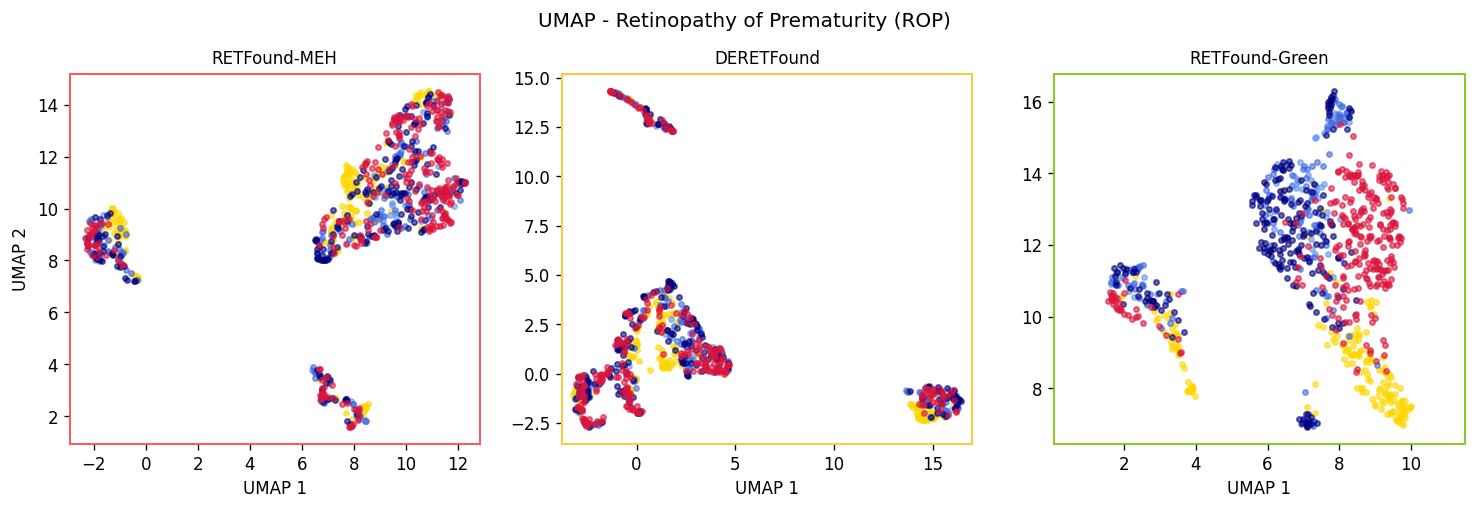

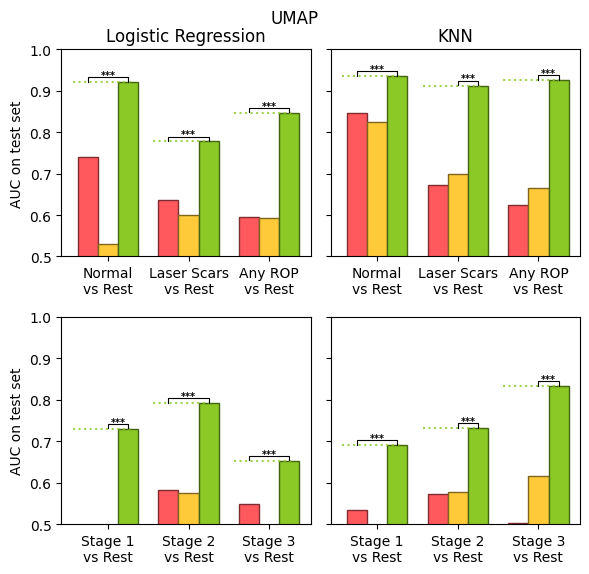

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=120)

target_cols = ['Normal', 'laser_scars', 'ROP', 'Stage_1_ROP', 'Stage_2_ROP', 'Stage_3_ROP']

projection_method_name = 'UMAP'
dim_name = 'UMAP'

results_df = pd.DataFrame()
bootstrap_results_dict = {}

for n_idx, (name, X_train_fname, X_test_fname) in enumerate(tqdm(name_X_list)):
    print(name)
    np.random.seed(42)
    X_train = np.load(X_train_fname)
    X_test = np.load(X_test_fname)

    y_train = dftrain[target_col]
    y_test = dftest[target_col]

    projector = umap.UMAP(metric='cosine', random_state=42, n_jobs=1)
    
    embedding = projector.fit_transform(X_train)
    embedding_test = projector.transform(X_test)

    logit = LogisticRegression(max_iter=10_000, random_state=42)
    knn = KNeighborsClassifier(n_jobs=-1)

    for target in target_cols:
        curr_y_train = y_train.apply(lambda x: x.endswith(target))
        curr_y_test = y_test.apply(lambda x: x.endswith(target))
        
        logit.fit(embedding, curr_y_train)
        logit_preds = logit.predict_proba(embedding_test)[:,1]
        logit_median_auc, logit_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, logit_preds)

        knn.fit(embedding, curr_y_train)
        knn_preds = knn.predict_proba(embedding_test)[:,1]
        knn_median_auc, knn_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, knn_preds)

        target = target.title().replace('_', ' ').replace('Rop', 'ROP')
        if target.startswith('ROP'):
            target = target.replace('ROP', 'Any ROP')
        elif target.endswith(' ROP'):
            target = target.replace(' ROP', '')
        
        results_df.loc[name, f'{target} vs rest - Logit'] = logit_median_auc
        results_df.loc[name, f'{target} vs rest - KNN'] = knn_median_auc

        bootstrap_results_dict[f'{name}-{target}-Logit'] = logit_bootstrap_aucs
        bootstrap_results_dict[f'{name}-{target}-KNN'] = knn_bootstrap_aucs


    for c_idx, c in enumerate(np.unique(y_train)):
        curr_mask = y_train==c
        
        ax[n_idx].scatter(
            embedding[:, 0][curr_mask],
            embedding[:, 1][curr_mask],
            alpha=0.6,
            s=10,
            label=c.title().replace('_', ' ').replace('Rop', 'ROP'),
            c=target_to_colour[c],
        )
        ax[n_idx].set_aspect('equal', 'datalim')
        ax[n_idx].set_title(name, fontsize='medium')
        ax[n_idx].set_xlabel(f'{dim_name} 1')
        if n_idx==0:
            ax[n_idx].set_ylabel(f'{dim_name} 2')

        for spine in ax[n_idx].spines.values():
            spine.set_edgecolor(colors[n_idx])
            spine.set_linewidth(1.2)

targets = ['Normal vs Rest', 'Laser Scars vs Rest', 'Any ROP vs Rest', 'Stage 1 vs Rest', 'Stage 2 vs Rest', 'Stage 3 vs Rest']
classifiers = ['Logit', 'KNN']
results_df.columns = pd.MultiIndex.from_product([targets, classifiers])

display(results_df.round(4))
plt.suptitle(f'{projection_method_name} - {dataset}', fontsize='large', y=1.01)
plt.show()


targets_row1 = ['Normal vs Rest', 'Laser Scars vs Rest', 'Any ROP vs Rest']
targets_row2 = ['Stage 1 vs Rest', 'Stage 2 vs Rest', 'Stage 3 vs Rest']
classifiers = ['Logit', 'KNN']

fig, ax = plt.subplots(2, 2, figsize=(6, 6))  # Side by side plots
(ax1, ax2, ax3, ax4) = ax.flat

for targets, axes in [(targets_row1, (ax1, ax2)), (targets_row2, (ax3, ax4))]:
    x = np.arange(len(targets))
    width = 0.25
    
    for ax, classifier in zip(axes, classifiers):
        for i, model in enumerate(models):
            values = [results_df.loc[model, (target, classifier)] for target in targets]
            locs = x + i*width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] - 2.75 * width
                    _right = locs[_idx] + 0.25 * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [bootstrap_results_dict[f'{name}-{target_str}-{classifier}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()
            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val+0.001, best_val+0.012, best_val+0.012, best_val+0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val<0.0001 else 0.01
            ax.text((start_loc+end_loc)/2, best_val +text_loc_height_offset, pval_to_str(p_val), ha='center', fontsize='x-small', 
                    weight=None  if not p_val<0.05 else 'bold')

            
        
        ax.set_xticks(x + width)
        targets_display = [_.replace(' vs', '\nvs') for _ in  targets]
        ax.set_xticklabels(targets_display, rotation=0, ha='center')
        ax.set_ylim(0.5, 1)


ax1.set_title('Logistic Regression')
ax2.set_title('KNN')
ax1.set_ylabel('AUC on test set')
ax3.set_ylabel('AUC on test set')
ax2.set_yticklabels([])
ax4.set_yticklabels([])

plt.suptitle(f'{projection_method_name}', y=0.95, fontsize='large')
plt.tight_layout()
plt.show()


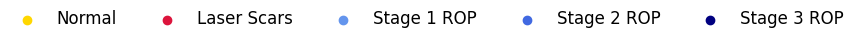

In [5]:
fig, ax = plt.subplots(figsize=(6, 0.2))
ax.axis('off')

for target in target_to_colour:
    ax.scatter([], [], label=target.title().replace('_', ' ').replace('Rop', 'ROP'), color=target_to_colour[target])

legend = ax.legend(loc='center', ncol=5, frameon=False, fontsize=12, borderpad =0)
plt.tight_layout(pad=0)
plt.show()

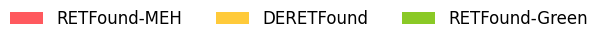

In [6]:
fig, ax = plt.subplots(figsize=(6, 0.2))
ax.axis('off')
models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green']
colors = ['#ff595e', '#ffca3a', '#8ac926']

for model, color in zip(models, colors):
    ax.bar(0, 0, color=color, label=model)

legend = ax.legend(loc='center', ncol=3, frameon=False, fontsize=12,borderpad =0)

plt.show()

/tmp/ipykernel_28229/1749907790.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=0)


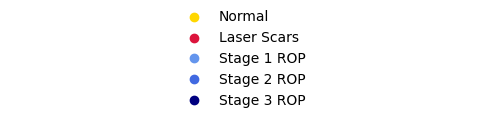

In [7]:
fig, ax = plt.subplots(figsize=(6, 0.2))
ax.axis('off')

for target in target_to_colour:
    ax.scatter([], [], label=target.title().replace('_', ' ').replace('Rop', 'ROP'), color=target_to_colour[target])

legend = ax.legend(loc='center', ncol=1, frameon=False, fontsize=10, borderpad =0)
plt.tight_layout(pad=0)
plt.show()

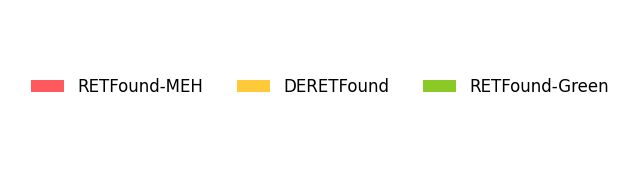

In [8]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green']
colors = ['#ff595e', '#ffca3a', '#8ac926']

for model, color in zip(models, colors):
    ax.bar(0, 0, color=color, label=model)

legend = ax.legend(loc='center', ncol=3, frameon=False, fontsize=12)

plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

RETFound-MEH
DERETFound
RETFound-Green


Normal vs Rest         Laser Scars vs Rest          \
                        Logit     KNN               Logit     KNN   
RETFound-MEH           0.7584  0.8154              0.6521  0.6896   
DERETFound             0.5141  0.8281              0.6002  0.7099   
RETFound-Green         0.9150  0.9319              0.8173  0.9329   

               Any ROP vs Rest         Stage 1 vs Rest          \
                         Logit     KNN           Logit     KNN   
RETFound-MEH            0.5827  0.6731          0.4392  0.6011   
DERETFound              0.6021  0.6705          0.4960  0.5819   
RETFound-Green          0.8445  0.9293          0.8065  0.7096   

               Stage 2 vs Rest         Stage 3 vs Rest          
                         Logit     KNN           Logit     KNN  
RETFound-MEH            0.5782  0.5533          0.4123  0.5557  
DERETFound              0.5865  0.6208          0.4422  0.6029  
RETFound-Green          0.7754  0.7598          0.6311  0.8153

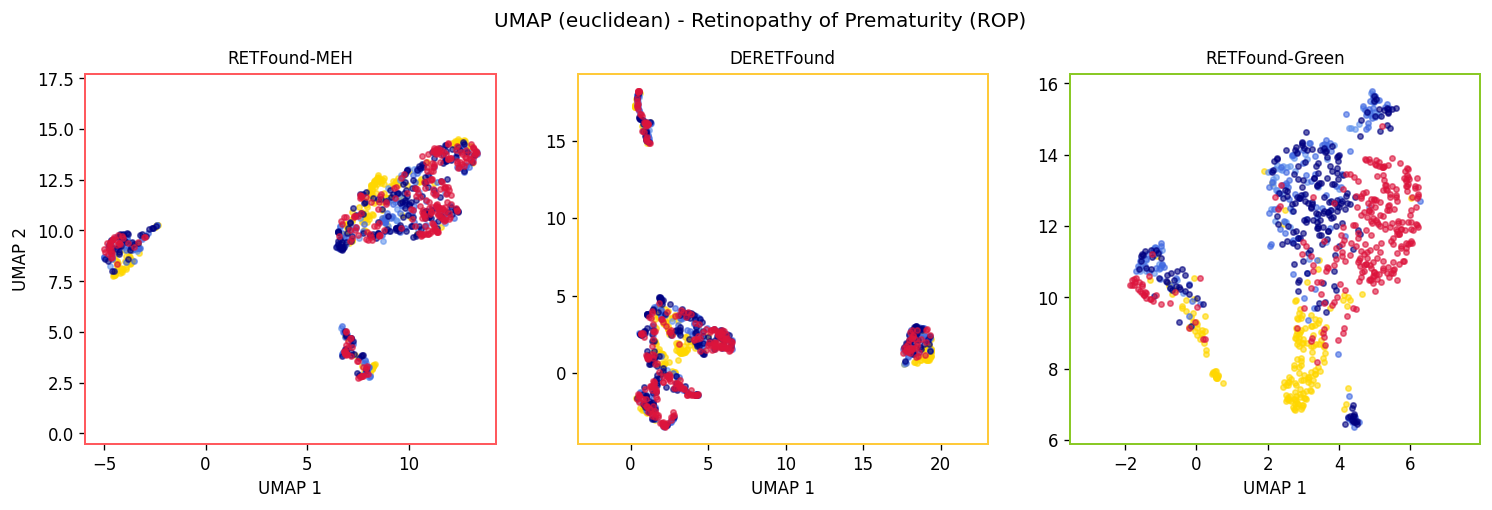

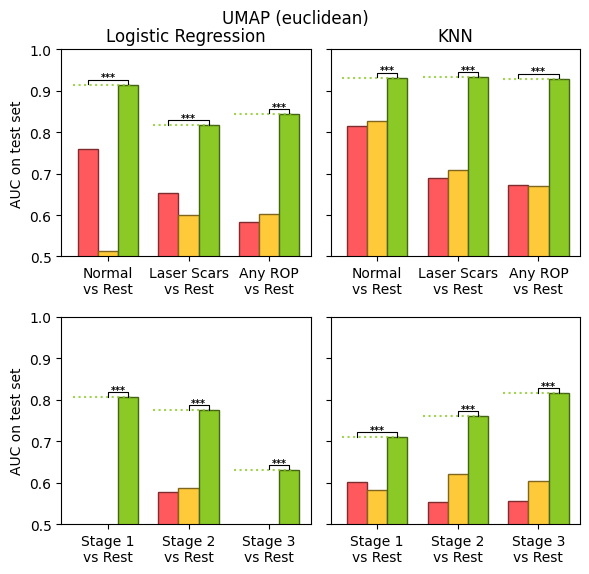

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=120)

target_cols = ['Normal', 'laser_scars', 'ROP', 'Stage_1_ROP', 'Stage_2_ROP', 'Stage_3_ROP']

projection_method_name = 'UMAP (euclidean)'
dim_name = 'UMAP'

results_df = pd.DataFrame()
bootstrap_results_dict = {}

for n_idx, (name, X_train_fname, X_test_fname) in enumerate(tqdm(name_X_list)):
    print(name)
    np.random.seed(42)
    X_train = np.load(X_train_fname)
    X_test = np.load(X_test_fname)

    y_train = dftrain[target_col]
    y_test = dftest[target_col]

    projector = umap.UMAP(metric='euclidean', random_state=42, n_jobs=1)

    embedding = projector.fit_transform(X_train)
    embedding_test = projector.transform(X_test)

    logit = LogisticRegression(max_iter=10_000, random_state=42)
    knn = KNeighborsClassifier(n_jobs=-1)

    for target in target_cols:
        curr_y_train = y_train.apply(lambda x: x.endswith(target))
        curr_y_test = y_test.apply(lambda x: x.endswith(target))
        
        logit.fit(embedding, curr_y_train)
        logit_preds = logit.predict_proba(embedding_test)[:,1]
        logit_median_auc, logit_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, logit_preds)

        knn.fit(embedding, curr_y_train)
        knn_preds = knn.predict_proba(embedding_test)[:,1]
        knn_median_auc, knn_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, knn_preds)

        target = target.title().replace('_', ' ').replace('Rop', 'ROP')
        if target.startswith('ROP'):
            target = target.replace('ROP', 'Any ROP')
        elif target.endswith(' ROP'):
            target = target.replace(' ROP', '')
        
        results_df.loc[name, f'{target} vs rest - Logit'] = logit_median_auc
        results_df.loc[name, f'{target} vs rest - KNN'] = knn_median_auc

        bootstrap_results_dict[f'{name}-{target}-Logit'] = logit_bootstrap_aucs
        bootstrap_results_dict[f'{name}-{target}-KNN'] = knn_bootstrap_aucs


    for c_idx, c in enumerate(np.unique(y_train)):
        curr_mask = y_train==c
        
        ax[n_idx].scatter(
            embedding[:, 0][curr_mask],
            embedding[:, 1][curr_mask],
            alpha=0.6,
            s=10,
            label=c.title().replace('_', ' ').replace('Rop', 'ROP'),
            c=target_to_colour[c],
        )
        ax[n_idx].set_aspect('equal', 'datalim')
        ax[n_idx].set_title(name, fontsize='medium')
        ax[n_idx].set_xlabel(f'{dim_name} 1')
        if n_idx==0:
            ax[n_idx].set_ylabel(f'{dim_name} 2')

        for spine in ax[n_idx].spines.values():
            spine.set_edgecolor(colors[n_idx])
            spine.set_linewidth(1.2)

targets = ['Normal vs Rest', 'Laser Scars vs Rest', 'Any ROP vs Rest', 'Stage 1 vs Rest', 'Stage 2 vs Rest', 'Stage 3 vs Rest']
classifiers = ['Logit', 'KNN']
results_df.columns = pd.MultiIndex.from_product([targets, classifiers])

display(results_df.round(4))
plt.suptitle(f'{projection_method_name} - {dataset}', fontsize='large', y=1.01)
plt.show()


targets_row1 = ['Normal vs Rest', 'Laser Scars vs Rest', 'Any ROP vs Rest']
targets_row2 = ['Stage 1 vs Rest', 'Stage 2 vs Rest', 'Stage 3 vs Rest']
classifiers = ['Logit', 'KNN']

fig, ax = plt.subplots(2, 2, figsize=(6, 6))  # Side by side plots
(ax1, ax2, ax3, ax4) = ax.flat

for targets, axes in [(targets_row1, (ax1, ax2)), (targets_row2, (ax3, ax4))]:
    x = np.arange(len(targets))
    width = 0.25
    
    for ax, classifier in zip(axes, classifiers):
        for i, model in enumerate(models):
            values = [results_df.loc[model, (target, classifier)] for target in targets]
            locs = x + i*width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] - 2.75 * width
                    _right = locs[_idx] + 0.25 * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [bootstrap_results_dict[f'{name}-{target_str}-{classifier}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()
            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val+0.001, best_val+0.012, best_val+0.012, best_val+0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val<0.0001 else 0.01
            ax.text((start_loc+end_loc)/2, best_val +text_loc_height_offset, pval_to_str(p_val), ha='center', fontsize='x-small', 
                    weight=None  if not p_val<0.05 else 'bold')

            
        
        ax.set_xticks(x + width)
        targets_display = [_.replace(' vs', '\nvs') for _ in  targets]
        ax.set_xticklabels(targets_display, rotation=0, ha='center')
        ax.set_ylim(0.5, 1)


ax1.set_title('Logistic Regression')
ax2.set_title('KNN')
ax1.set_ylabel('AUC on test set')
ax3.set_ylabel('AUC on test set')
ax2.set_yticklabels([])
ax4.set_yticklabels([])

plt.suptitle(f'{projection_method_name}', y=0.95, fontsize='large')
plt.tight_layout()
plt.show()


  0%|          | 0/3 [00:00<?, ?it/s]

RETFound-MEH
DERETFound
RETFound-Green


Normal vs Rest         Laser Scars vs Rest          \
                        Logit     KNN               Logit     KNN   
RETFound-MEH           0.7362  0.7937              0.6624  0.6615   
DERETFound             0.6013  0.8230              0.6014  0.7238   
RETFound-Green         0.9071  0.9285              0.7831  0.9200   

               Any ROP vs Rest         Stage 1 vs Rest          \
                         Logit     KNN           Logit     KNN   
RETFound-MEH            0.6080  0.6064          0.4528  0.5818   
DERETFound              0.5579  0.6925          0.4570  0.5856   
RETFound-Green          0.8509  0.9172          0.8236  0.7423   

               Stage 2 vs Rest         Stage 3 vs Rest          
                         Logit     KNN           Logit     KNN  
RETFound-MEH            0.6027  0.5451          0.5419  0.4796  
DERETFound              0.5513  0.5772          0.4286  0.6180  
RETFound-Green          0.8035  0.7613          0.5882  0.7519

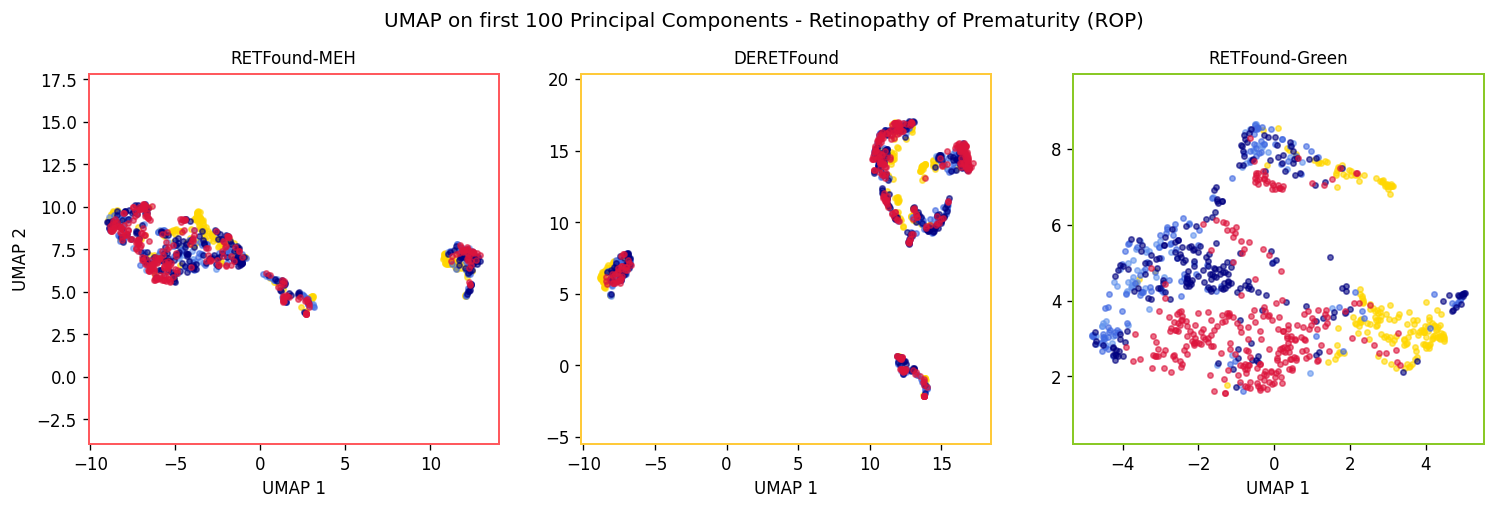

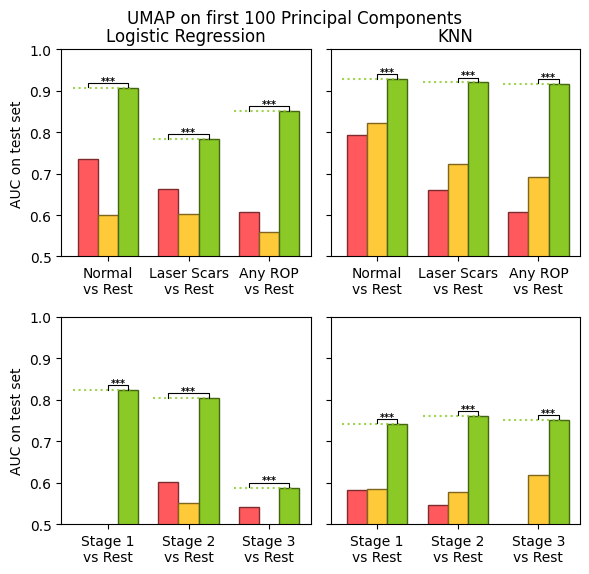

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=120)

target_cols = ['Normal', 'laser_scars', 'ROP', 'Stage_1_ROP', 'Stage_2_ROP', 'Stage_3_ROP']

projection_method_name = 'UMAP on first 100 Principal Components'
dim_name = 'UMAP'

results_df = pd.DataFrame()
bootstrap_results_dict = {}

for n_idx, (name, X_train_fname, X_test_fname) in enumerate(tqdm(name_X_list)):
    print(name)
    np.random.seed(42)
    X_train = np.load(X_train_fname)
    X_test = np.load(X_test_fname)

    y_train = dftrain[target_col]
    y_test = dftest[target_col]
    
    projector = umap.UMAP(metric='cosine', random_state=42, n_jobs=1)
    projector = make_pipeline(PCA(n_components=100), projector)
    
    embedding = projector.fit_transform(X_train)
    embedding_test = projector.transform(X_test)

    logit = LogisticRegression(max_iter=10_000, random_state=42)
    knn = KNeighborsClassifier(n_jobs=-1)

    for target in target_cols:
        curr_y_train = y_train.apply(lambda x: x.endswith(target))
        curr_y_test = y_test.apply(lambda x: x.endswith(target))
        
        logit.fit(embedding, curr_y_train)
        logit_preds = logit.predict_proba(embedding_test)[:,1]
        logit_median_auc, logit_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, logit_preds)

        knn.fit(embedding, curr_y_train)
        knn_preds = knn.predict_proba(embedding_test)[:,1]
        knn_median_auc, knn_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, knn_preds)

        target = target.title().replace('_', ' ').replace('Rop', 'ROP')
        if target.startswith('ROP'):
            target = target.replace('ROP', 'Any ROP')
        elif target.endswith(' ROP'):
            target = target.replace(' ROP', '')
        
        results_df.loc[name, f'{target} vs rest - Logit'] = logit_median_auc
        results_df.loc[name, f'{target} vs rest - KNN'] = knn_median_auc

        bootstrap_results_dict[f'{name}-{target}-Logit'] = logit_bootstrap_aucs
        bootstrap_results_dict[f'{name}-{target}-KNN'] = knn_bootstrap_aucs


    for c_idx, c in enumerate(np.unique(y_train)):
        curr_mask = y_train==c
        
        ax[n_idx].scatter(
            embedding[:, 0][curr_mask],
            embedding[:, 1][curr_mask],
            alpha=0.6,
            s=10,
            label=c.title().replace('_', ' ').replace('Rop', 'ROP'),
            c=target_to_colour[c],
        )
        ax[n_idx].set_aspect('equal', 'datalim')
        ax[n_idx].set_title(name, fontsize='medium')
        ax[n_idx].set_xlabel(f'{dim_name} 1')
        if n_idx==0:
            ax[n_idx].set_ylabel(f'{dim_name} 2')

        for spine in ax[n_idx].spines.values():
            spine.set_edgecolor(colors[n_idx])
            spine.set_linewidth(1.2)

targets = ['Normal vs Rest', 'Laser Scars vs Rest', 'Any ROP vs Rest', 'Stage 1 vs Rest', 'Stage 2 vs Rest', 'Stage 3 vs Rest']
classifiers = ['Logit', 'KNN']
results_df.columns = pd.MultiIndex.from_product([targets, classifiers])

display(results_df.round(4))
plt.suptitle(f'{projection_method_name} - {dataset}', fontsize='large', y=1.01)
plt.show()


targets_row1 = ['Normal vs Rest', 'Laser Scars vs Rest', 'Any ROP vs Rest']
targets_row2 = ['Stage 1 vs Rest', 'Stage 2 vs Rest', 'Stage 3 vs Rest']
classifiers = ['Logit', 'KNN']

fig, ax = plt.subplots(2, 2, figsize=(6, 6))  # Side by side plots
(ax1, ax2, ax3, ax4) = ax.flat

for targets, axes in [(targets_row1, (ax1, ax2)), (targets_row2, (ax3, ax4))]:
    x = np.arange(len(targets))
    width = 0.25
    
    for ax, classifier in zip(axes, classifiers):
        for i, model in enumerate(models):
            values = [results_df.loc[model, (target, classifier)] for target in targets]
            locs = x + i*width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] - 2.75 * width
                    _right = locs[_idx] + 0.25 * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [bootstrap_results_dict[f'{name}-{target_str}-{classifier}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()
            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val+0.001, best_val+0.012, best_val+0.012, best_val+0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val<0.0001 else 0.01
            ax.text((start_loc+end_loc)/2, best_val +text_loc_height_offset, pval_to_str(p_val), ha='center', fontsize='x-small', 
                    weight=None  if not p_val<0.05 else 'bold')

            
        
        ax.set_xticks(x + width)
        targets_display = [_.replace(' vs', '\nvs') for _ in  targets]
        ax.set_xticklabels(targets_display, rotation=0, ha='center')
        ax.set_ylim(0.5, 1)


ax1.set_title('Logistic Regression')
ax2.set_title('KNN')
ax1.set_ylabel('AUC on test set')
ax3.set_ylabel('AUC on test set')
ax2.set_yticklabels([])
ax4.set_yticklabels([])

plt.suptitle(f'{projection_method_name}', y=0.95, fontsize='large')
plt.tight_layout()
plt.show()


  0%|          | 0/3 [00:00<?, ?it/s]

RETFound-MEH
DERETFound
RETFound-Green


Normal vs Rest         Laser Scars vs Rest          \
                        Logit     KNN               Logit     KNN   
RETFound-MEH           0.7563  0.8291              0.6368  0.7085   
DERETFound             0.4518  0.8164              0.5796  0.7192   
RETFound-Green         0.9301  0.9394              0.7920  0.9083   

               Any ROP vs Rest         Stage 1 vs Rest          \
                         Logit     KNN           Logit     KNN   
RETFound-MEH            0.5773  0.6591          0.4147  0.6182   
DERETFound              0.5681  0.6661          0.4392  0.5133   
RETFound-Green          0.8545  0.9381          0.7841  0.7038   

               Stage 2 vs Rest         Stage 3 vs Rest          
                         Logit     KNN           Logit     KNN  
RETFound-MEH            0.5708  0.5471          0.4230  0.5620  
DERETFound              0.5385  0.5877          0.4180  0.6019  
RETFound-Green          0.7966  0.7649          0.6472  0.7636

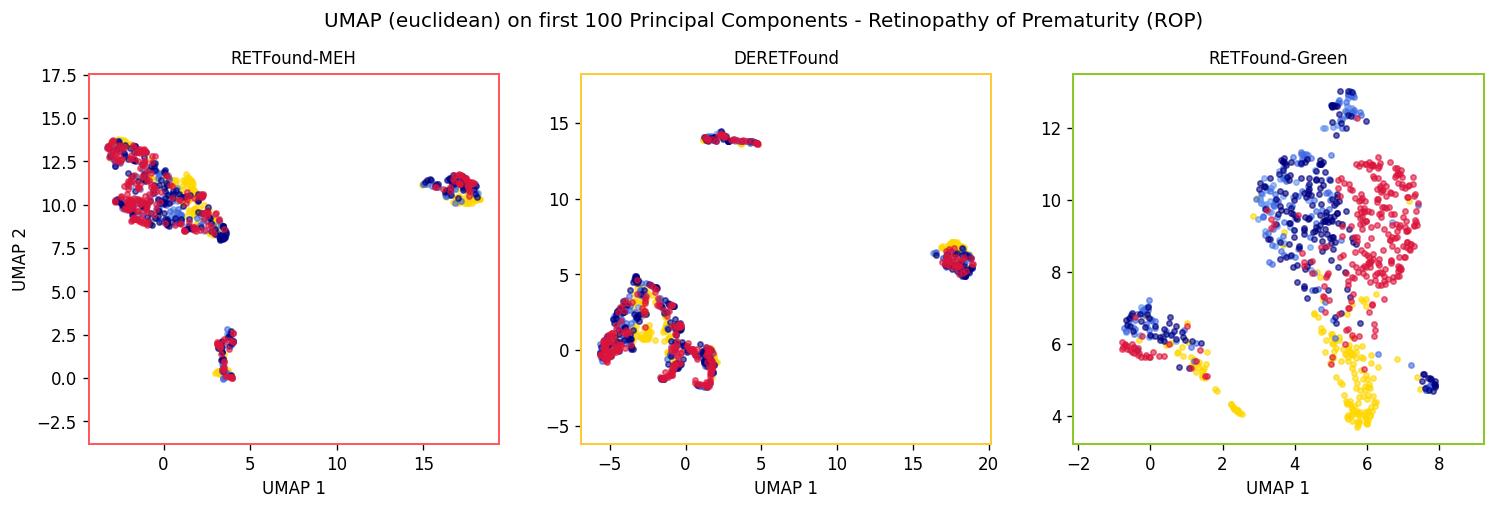

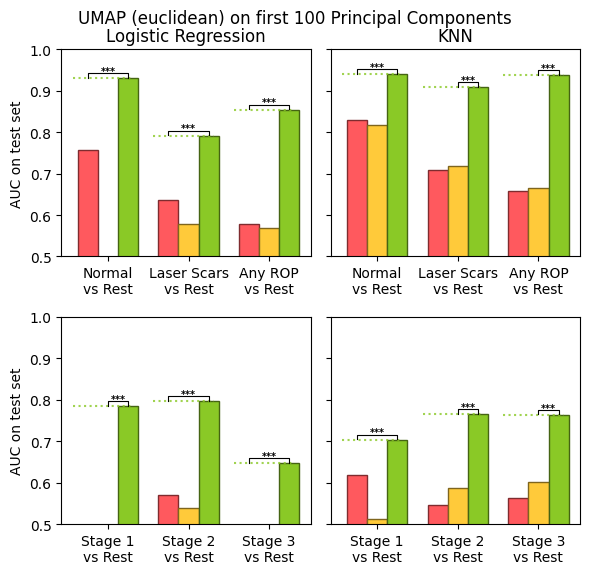

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=120)

target_cols = ['Normal', 'laser_scars', 'ROP', 'Stage_1_ROP', 'Stage_2_ROP', 'Stage_3_ROP']

projection_method_name = 'UMAP (euclidean) on first 100 Principal Components'
dim_name = 'UMAP'

results_df = pd.DataFrame()
bootstrap_results_dict = {}

for n_idx, (name, X_train_fname, X_test_fname) in enumerate(tqdm(name_X_list)):
    print(name)
    np.random.seed(42)
    X_train = np.load(X_train_fname)
    X_test = np.load(X_test_fname)

    y_train = dftrain[target_col]
    y_test = dftest[target_col]
    
    projector = umap.UMAP(metric='euclidean', random_state=42, n_jobs=1)
    projector = make_pipeline(PCA(n_components=100), projector)

    embedding = projector.fit_transform(X_train)
    embedding_test = projector.transform(X_test)

    logit = LogisticRegression(max_iter=10_000, random_state=42)
    knn = KNeighborsClassifier(n_jobs=-1)

    for target in target_cols:
        curr_y_train = y_train.apply(lambda x: x.endswith(target))
        curr_y_test = y_test.apply(lambda x: x.endswith(target))
        
        logit.fit(embedding, curr_y_train)
        logit_preds = logit.predict_proba(embedding_test)[:,1]
        logit_median_auc, logit_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, logit_preds)

        knn.fit(embedding, curr_y_train)
        knn_preds = knn.predict_proba(embedding_test)[:,1]
        knn_median_auc, knn_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, knn_preds)

        target = target.title().replace('_', ' ').replace('Rop', 'ROP')
        if target.startswith('ROP'):
            target = target.replace('ROP', 'Any ROP')
        elif target.endswith(' ROP'):
            target = target.replace(' ROP', '')
        
        results_df.loc[name, f'{target} vs rest - Logit'] = logit_median_auc
        results_df.loc[name, f'{target} vs rest - KNN'] = knn_median_auc

        bootstrap_results_dict[f'{name}-{target}-Logit'] = logit_bootstrap_aucs
        bootstrap_results_dict[f'{name}-{target}-KNN'] = knn_bootstrap_aucs


    for c_idx, c in enumerate(np.unique(y_train)):
        curr_mask = y_train==c
        
        ax[n_idx].scatter(
            embedding[:, 0][curr_mask],
            embedding[:, 1][curr_mask],
            alpha=0.6,
            s=10,
            label=c.title().replace('_', ' ').replace('Rop', 'ROP'),
            c=target_to_colour[c],
        )
        ax[n_idx].set_aspect('equal', 'datalim')
        ax[n_idx].set_title(name, fontsize='medium')
        ax[n_idx].set_xlabel(f'{dim_name} 1')
        if n_idx==0:
            ax[n_idx].set_ylabel(f'{dim_name} 2')

        for spine in ax[n_idx].spines.values():
            spine.set_edgecolor(colors[n_idx])
            spine.set_linewidth(1.2)

targets = ['Normal vs Rest', 'Laser Scars vs Rest', 'Any ROP vs Rest', 'Stage 1 vs Rest', 'Stage 2 vs Rest', 'Stage 3 vs Rest']
classifiers = ['Logit', 'KNN']
results_df.columns = pd.MultiIndex.from_product([targets, classifiers])

display(results_df.round(4))
plt.suptitle(f'{projection_method_name} - {dataset}', fontsize='large', y=1.01)
plt.show()


targets_row1 = ['Normal vs Rest', 'Laser Scars vs Rest', 'Any ROP vs Rest']
targets_row2 = ['Stage 1 vs Rest', 'Stage 2 vs Rest', 'Stage 3 vs Rest']
classifiers = ['Logit', 'KNN']

fig, ax = plt.subplots(2, 2, figsize=(6, 6))  # Side by side plots
(ax1, ax2, ax3, ax4) = ax.flat

for targets, axes in [(targets_row1, (ax1, ax2)), (targets_row2, (ax3, ax4))]:
    x = np.arange(len(targets))
    width = 0.25
    
    for ax, classifier in zip(axes, classifiers):
        for i, model in enumerate(models):
            values = [results_df.loc[model, (target, classifier)] for target in targets]
            locs = x + i*width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] - 2.75 * width
                    _right = locs[_idx] + 0.25 * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [bootstrap_results_dict[f'{name}-{target_str}-{classifier}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()
            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val+0.001, best_val+0.012, best_val+0.012, best_val+0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val<0.0001 else 0.01
            ax.text((start_loc+end_loc)/2, best_val +text_loc_height_offset, pval_to_str(p_val), ha='center', fontsize='x-small', 
                    weight=None  if not p_val<0.05 else 'bold')

            
        
        ax.set_xticks(x + width)
        targets_display = [_.replace(' vs', '\nvs') for _ in  targets]
        ax.set_xticklabels(targets_display, rotation=0, ha='center')
        ax.set_ylim(0.5, 1)


ax1.set_title('Logistic Regression')
ax2.set_title('KNN')
ax1.set_ylabel('AUC on test set')
ax3.set_ylabel('AUC on test set')
ax2.set_yticklabels([])
ax4.set_yticklabels([])

plt.suptitle(f'{projection_method_name}', y=0.95, fontsize='large')
plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=120)

target_cols = ['Normal', 'laser_scars', 'ROP', 'Stage_1_ROP', 'Stage_2_ROP', 'Stage_3_ROP']

projection_method_name = 'UMAP'
dim_name = 'UMAP'

results_df = pd.DataFrame()
bootstrap_results_dict = {}

for n_idx, (name, X_train_fname, X_test_fname) in enumerate(tqdm(name_X_list)):
    print(name)
    np.random.seed(42)
    X_train = np.load(X_train_fname)
    X_test = np.load(X_test_fname)

    y_train = dftrain[target_col]
    y_test = dftest[target_col]

    projector = umap.UMAP(metric='cosine', random_state=42, n_jobs=1)
    
    embedding = projector.fit_transform(X_train)
    embedding_test = projector.transform(X_test)

    logit = LogisticRegression(max_iter=10_000, random_state=42)
    knn = KNeighborsClassifier(n_jobs=-1)

    for target in target_cols:
        curr_y_train = y_train.apply(lambda x: x.endswith(target))
        curr_y_test = y_test.apply(lambda x: x.endswith(target))
        
        logit.fit(embedding, curr_y_train)
        logit_preds = logit.predict_proba(embedding_test)[:,1]
        logit_median_auc, logit_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, logit_preds)

        knn.fit(embedding, curr_y_train)
        knn_preds = knn.predict_proba(embedding_test)[:,1]
        knn_median_auc, knn_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, knn_preds)

        target = target.title().replace('_', ' ').replace('Rop', 'ROP')
        if target.startswith('ROP'):
            target = target.replace('ROP', 'Any ROP')
        elif target.endswith(' ROP'):
            target = target.replace(' ROP', '')
        
        results_df.loc[name, f'{target} vs rest - Logit'] = logit_median_auc
        results_df.loc[name, f'{target} vs rest - KNN'] = knn_median_auc

        bootstrap_results_dict[f'{name}-{target}-Logit'] = logit_bootstrap_aucs
        bootstrap_results_dict[f'{name}-{target}-KNN'] = knn_bootstrap_aucs


    for c_idx, c in enumerate(np.unique(y_train)):
        curr_mask = y_train==c
        
        ax[n_idx].scatter(
            embedding[:, 0][curr_mask],
            embedding[:, 1][curr_mask],
            alpha=0.6,
            s=10,
            label=c.title().replace('_', ' ').replace('Rop', 'ROP'),
            c=target_to_colour[c],
        )
        ax[n_idx].set_aspect('equal', 'datalim')
        ax[n_idx].set_title(name, fontsize='medium')
        ax[n_idx].set_xlabel(f'{dim_name} 1')
        if n_idx==0:
            ax[n_idx].set_ylabel(f'{dim_name} 2')

        for spine in ax[n_idx].spines.values():
            spine.set_edgecolor(colors[n_idx])
            spine.set_linewidth(1.2)

targets = ['Normal vs Rest', 'Laser Scars vs Rest', 'Any ROP vs Rest', 'Stage 1 vs Rest', 'Stage 2 vs Rest', 'Stage 3 vs Rest']
classifiers = ['Logit', 'KNN']
results_df.columns = pd.MultiIndex.from_product([targets, classifiers])

display(results_df.round(4))
plt.suptitle(f'{projection_method_name} - {dataset}', fontsize='large', y=1.01)
plt.show()


targets_row1 = ['Normal vs Rest', 'Laser Scars vs Rest', 'Any ROP vs Rest']
targets_row2 = ['Stage 1 vs Rest', 'Stage 2 vs Rest', 'Stage 3 vs Rest']
classifiers = ['Logit', 'KNN']

fig, ax = plt.subplots(2, 2, figsize=(6, 6))  # Side by side plots
(ax1, ax2, ax3, ax4) = ax.flat

for targets, axes in [(targets_row1, (ax1, ax2)), (targets_row2, (ax3, ax4))]:
    x = np.arange(len(targets))
    width = 0.25
    
    for ax, classifier in zip(axes, classifiers):
        for i, model in enumerate(models):
            values = [results_df.loc[model, (target, classifier)] for target in targets]
            locs = x + i*width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] - 2.75 * width
                    _right = locs[_idx] + 0.25 * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [bootstrap_results_dict[f'{name}-{target_str}-{classifier}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()
            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val+0.001, best_val+0.012, best_val+0.012, best_val+0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val<0.0001 else 0.01
            ax.text((start_loc+end_loc)/2, best_val +text_loc_height_offset, pval_to_str(p_val), ha='center', fontsize='x-small', 
                    weight=None  if not p_val<0.05 else 'bold')

            
        
        ax.set_xticks(x + width)
        targets_display = [_.replace(' vs', '\nvs') for _ in  targets]
        ax.set_xticklabels(targets_display, rotation=0, ha='center')
        ax.set_ylim(0.5, 1)


ax1.set_title('Logistic Regression')
ax2.set_title('KNN')
ax1.set_ylabel('AUC on test set')
ax3.set_ylabel('AUC on test set')
ax2.set_yticklabels([])
ax4.set_yticklabels([])

plt.suptitle(f'{projection_method_name}', y=0.95, fontsize='large')
plt.tight_layout()
plt.show()
